<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"><li><span><a href="#Question-1" data-toc-modified-id="Question-1-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Question 1</a></span></li><li><span><a href="#Question-2" data-toc-modified-id="Question-2-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Question 2</a></span></li><li><span><a href="#Question-3" data-toc-modified-id="Question-3-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Question 3</a></span></li></ul></div>

# Question 1

**Question**

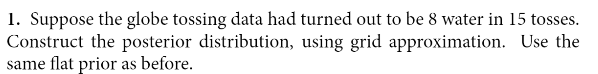

**Solution**

In [1]:
using Distributions
using StatsBase

const tosses = 15
const water = 8

# we want to infer the value of p, which is continuous
# so we discretize it to 1,000 possible values
# each value represents our hypothesis of the value
# of p
p_grid = range(0, 1, length = 1000)

# we assume a uniform prior, so for each value of p,
# we assign equal weight
# the value of the weight does not matter, as long as
# they are equal
p_prior = fill(1, 1000)

# compute the probability of the observations given
# each value of p i.e. likelihood of data
prob_data = map(p_grid) do p
    d = Binomial(tosses, p)
    pdf(d, water)
end

# update the prior probability of observing a specific
# value of p
p_posterior = prob_data .* p_prior # the numerator in bayes formula
normalizing_constant = sum(p_posterior)
p_posterior = p_posterior ./ normalizing_constant

# sample some values of p based on its posterior distribution
p_posterior = weights(p_posterior)
samples = sample(p_grid, p_posterior, 10000, replace = true);

In [2]:
p_posterior_mean = round(mean(samples), digits = 2)
lower_bound, upper_bound = round.(quantile(samples, [0.005, 0.995]), digits = 2)
println("The posterior mean is $p_posterior_mean")
println("The 99% percentile interval is ($(lower_bound), $(upper_bound))")

The posterior mean is 0.53
The 99% percentile interval is (0.25, 0.81)


# Question 2

**Question**

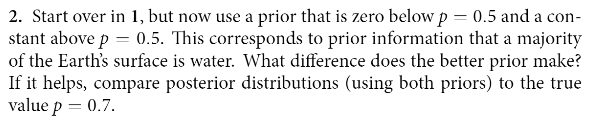

**Solution**

In [3]:
using Distributions
using StatsBase

const tosses = 15
const water = 8

# we want to infer the value of p, which is continuous
# so we discretize it to 1,000 possible values
# each value represents our hypothesis of the value
# of p
p_grid = range(0, 1, length = 1000)

# our prior is 0 for any value of p < 0.50 and
# uniform for any p >= 0.50
p_prior = fill(1, 1000)
p_prior[1:500] .= 0

# compute the probability of the observations given
# each value of p i.e. likelihood of data
prob_data = map(p_grid) do p
    d = Binomial(tosses, p)
    pdf(d, water)
end

# update the prior probability of observing a specific
# value of p
p_posterior = prob_data .* p_prior # the numerator in bayes formula
normalizing_constant = sum(p_posterior)
p_posterior = p_posterior ./ normalizing_constant

# sample some values of p based on its posterior distribution
p_posterior = weights(p_posterior)
samples2 = sample(p_grid, p_posterior, 10000, replace = true)

p_posterior_mean = round(mean(samples2), digits = 2)
lower_bound, upper_bound = round.(quantile(samples2, [0.005, 0.995]), digits = 2)
println("The posterior mean is $p_posterior_mean")
println("The 99% percentile interval is ($(lower_bound), $(upper_bound))")

The posterior mean is 0.61
The 99% percentile interval is (0.5, 0.82)


Compare the $p$'s posterior from Q1, Q2 and the true value:

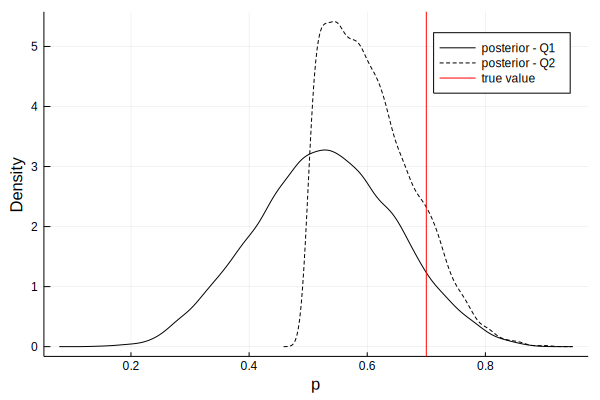

In [4]:
using Plots
using StatsPlots

density(samples, label = "posterior - Q1", color = :black, xlabel = "p", ylabel = "Density")
density!(samples2, label = "posterior - Q2", color = :black, linestyle = :dash)
vline!([0.7], label = "true value", color = :red)

**Conclusion**

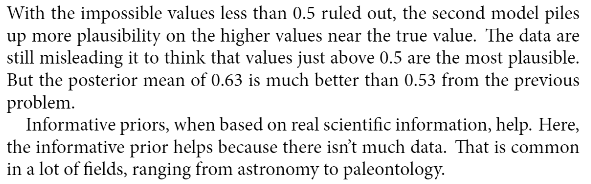

# Question 3

**Question**
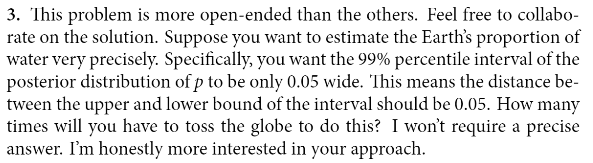

**Solution**

Some utility functions to help run the simulation:

In [5]:
using Distributions
using StatsBase

const PercentileInterval = Tuple{Float64,Float64}

function percentile_interval(
    samples::Array{Float64,1},
    level::Float64 = 0.99,
)::PercentileInterval
    tail_val = (1 - level) / 2
    p = [tail_val, 1 - tail_val]
    lower_bound, upper_bound = quantile(samples, p) |> Tuple
end

interval_width((lower, upper)::PercentileInterval) = upper - lower

generate_outcome(N::Int)::Int = begin
    true_p = 0.70
    d = Binomial(N, true_p)
    observed_W = rand(d)
    return observed_W
end

likelihood_data(outcome::Int, p_grid::StepRangeLen, tosses::Int)::Array{Float64} =
    begin
        map(p_grid) do p
            d = Binomial(tosses, p)
            pdf(d, outcome)
        end
    end

update_prior(likelihood::Array{Float64,1}, prior::Array{Float64,1})::Array{Float64, 1} =
    begin
        posterior = similar(prior, Float64)
        posterior .= likelihood .* prior # the numerator in bayes formula
        normalizing_constant = sum(posterior)
        posterior .= posterior ./ normalizing_constant
    end
;

The function we are going to simulate:

In [6]:
function toss_globe(tosses::Int)::Float64
    # number of Water outcomes
    observed_W = generate_outcome(tosses)

    p_grid = range(0, 1, length = 1000)
    p_prior = fill(1.0, 1000)

    likelihood = likelihood_data(observed_W, p_grid, tosses)
    p_posterior = update_prior(likelihood, p_prior)

    p_posterior = weights(p_posterior)
    samples = sample(p_grid, p_posterior, 10000, replace = true)

    interval = percentile_interval(samples)
    width = interval_width(interval)

    return width

end;

Run the simulation:

In [7]:
sizes = [20, 50, 100, 200, 500, 1000, 2000]
num_tosses = fill(sizes, 100) |> Iterators.flatten |> collect
interval_widths = map(n -> toss_globe(n), num_tosses);

Plot the results:

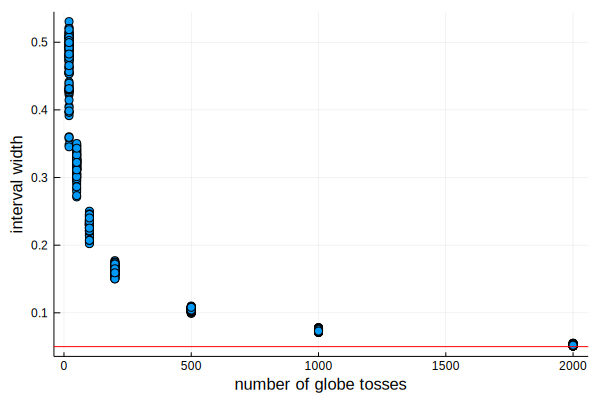

In [8]:
using Plots

scatter(num_tosses, interval_widths, xlabel="number of globe tosses", ylabel="interval width")
hline!([0.05], color=:red, legend=false)

**Conclusion**

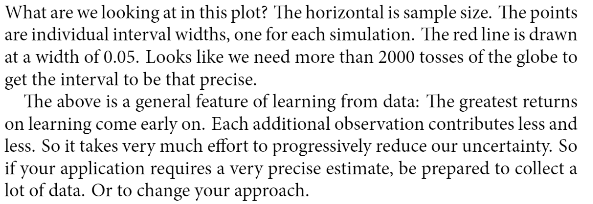